## Importing dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import os
import pickle
from tqdm.notebook import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# Inception network
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3

# image and text processing
from tensorflow.keras.preprocessing.image import load_img, img_to_array  
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard

from nltk.translate.bleu_score import corpus_bleu 

## Loading the pre-trained Convolutional Net

In [ ]:
inception_model = InceptionV3(include_top = False)

In [ ]:
print(inception_model.summary())

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        864 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │      9,216 │ activation[0][0]  │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     18,432 │ activation_1[0][… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │      5,120 │ max_pooling2d[0]… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │    138,240 │ activation_3[0][… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, None,      │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


## Extracting features from the image

In [ ]:
# extracting image features using Inception network
features = {}
directory = os.path.join(BASE_DIR, 'flickr30k_images')
files = os.listdir(directory)

for img_name in tqdm(files):
    image_path = os.path.join(directory, img_name)
    image = load_img(image_path, target_size = (224, 224))
    image = img_to_array(image)
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
    image = preprocess_input(image)
    feature = inception_model.predict(image, verbose = 0)
    image_id = img_name.split(".")[0]
    features[image_id] = feature
    if len(features) % 1000 == 0:
        print(len(features))

In [ ]:
with open(os.path.join(WORKING_DIR2, "features30k.pkl"), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(BASE_DIR, "captions.txt"), 'r') as f:
    next(f)
    caption_doc = f.read()

In [ ]:
# image to caption mapping
mapping = {}

# the captions are in the format
# 1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .

for line in caption_doc.split("\n"):
    tokens = line.split(",")
    if len(line) < 2:
        continue
    
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split(".")[0]
    caption = " ".join(caption)
    
    if image_id not in mapping.keys():
        mapping[image_id] = []
        
    mapping[image_id].append(caption)

## Preprocesssing text data

In [ ]:
def clean(mapping):
    for _, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            
            caption = caption.lower()
            caption = caption.replace('[^a-zA-Z]', "")
            caption = caption.replace('\s+', " ") 
            caption = "startseq " + " ".join([word for word in caption.split() if len(word)>1]) + " endseq"
            captions[i] = caption

In [ ]:
print(f"Before preprocessing: {mapping[list(mapping.keys())[0]]}")
clean(mapping)
print(f"After preprocessing: {mapping[list(mapping.keys())[0]]}")

Before preprocessing: ['0 Two young guys with shaggy hair look at their hands while hanging out in the yard .', '1 Two young  White males are outside near many bushes .', '2 Two men in green shirts are standing in a yard .', '3 A man in a blue shirt standing in a garden .', '4 Two friends enjoy time spent together .']
After preprocessing: ['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq', 'startseq two young white males are outside near many bushes endseq', 'startseq two men in green shirts are standing in yard endseq', 'startseq man in blue shirt standing in garden endseq', 'startseq two friends enjoy time spent together endseq']


In [ ]:
processed_captions = []
for key in mapping:
    for caption in mapping[key]:
        processed_captions.append(caption)

In [ ]:
len(processed_captions) # every image has ~5 captions

158915

In [ ]:
processed_captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

## Tokenizing the text

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_captions)

vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 18319


In [ ]:
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [ ]:
with open('tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

In [ ]:
vocab_size

18319

In [ ]:
# get maximum length of the caption
max_length = max(len(caption.split()) for caption in processed_captions)
max_length

74

## Train test split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * .6) #60% train, 20% validation, 20% test split
split2 = int(len(image_ids) * 0.8)

train_set = image_ids[:split]
validation_set = image_ids[split:split2]
test_set = image_ids[split2: ]

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    """
    Acts as a generator. Can be used to feed data into the maodel in batches
    
    Input: 
    data_keys --> an array of image IDs
    mapping --> dictionary where image IDs are the keys and the extracted image features are the values
    tokenizer --> the tensorflow tokenizer instance that you want to use
    max_length --> maximum length of the sequence
    voacb_size --> the number of unique words in your Corpus
    batch_size --> the number of images that you want to feed to your model at once
    
    Output:
    [image_features, input_sequnce], output_sequence
    """
    X1, X2, y = [], [], []
    n = 0
    while True: 
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions: 
                seq = tokenizer.texts_to_sequences([caption])[0] # encoding the sequence
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0] 
                    
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if n == batch_size: 
                X1 = np.array(X1)
                X2 = np.array(X2)
                y = np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = [], [], []
                n = 0

## Model Creation

In [ ]:
Embedding?

Init signature:
Embedding(
    input_dim,
    output_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    weights=None,
    lora_rank=None,
    **kwargs,
)
Docstring:     
Turns positive integers (indexes) into dense vectors of fixed size.

e.g. `[[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]`

This layer can only be used on positive integer inputs of a fixed range.

Example:

>>> model = keras.Sequential()
>>> model.add(keras.layers.Embedding(1000, 64))
>>> # The model will take as input an integer matrix of size (batch,
>>> # input_length), and the largest integer (i.e. word index) in the input
>>> # should be no larger than 999 (vocabulary size).
>>> # Now model.output_shape is (None, 10, 64), where `None` is the batch
>>> # dimension.
>>> input_array = np.random.randint(1000, size=(32, 10))
>>> model.compile('rmsprop', 'mse')
>>> output_array = model.predict(input_array)
>>> print(output_array.shape)
(32, 10

In [ ]:
def build_model(vocab_size, max_length):
    """
    Builds and returns an image captioning model that combines image features with sequence data 
    to predict the next word in a caption.
    
    Input: 
    vocab_size --> the number of unique words in your corpus
    max_length --> the maximum nummber of words in a single caption
    
    Output:
    An instance of Tensorflow Model class
    """
    
    # ENCODER MODEL
    # image model
    inputs1 = Input(shape = (5, 5, 2048, ), name = "image")
    x1 = GlobalAveragePooling2D()(inputs1)
    fe1 = Dropout(0.35)(x1)
    fe2 = Dense(256, activation = 'relu')(fe1)

    # sequence model
    inputs2 = Input(shape = (max_length,), name = "text")
    se1 = Embedding(vocab_size, 256, mask_zero = False)(inputs2)
    se2 = Dropout(0.35)(se1)
    se3 = LSTM(256, use_cudnn = False)(se2)

    # DECODER MODEL
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation = 'relu')(decoder1)
    outputs = Dense(vocab_size, activation = "softmax")(decoder2)


    model = Model(inputs = [inputs1, inputs2], outputs = outputs)
    return model

In [ ]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = build_model(vocab_size = vocab_size, max_length = max_length)
    model.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate = 0.0001))

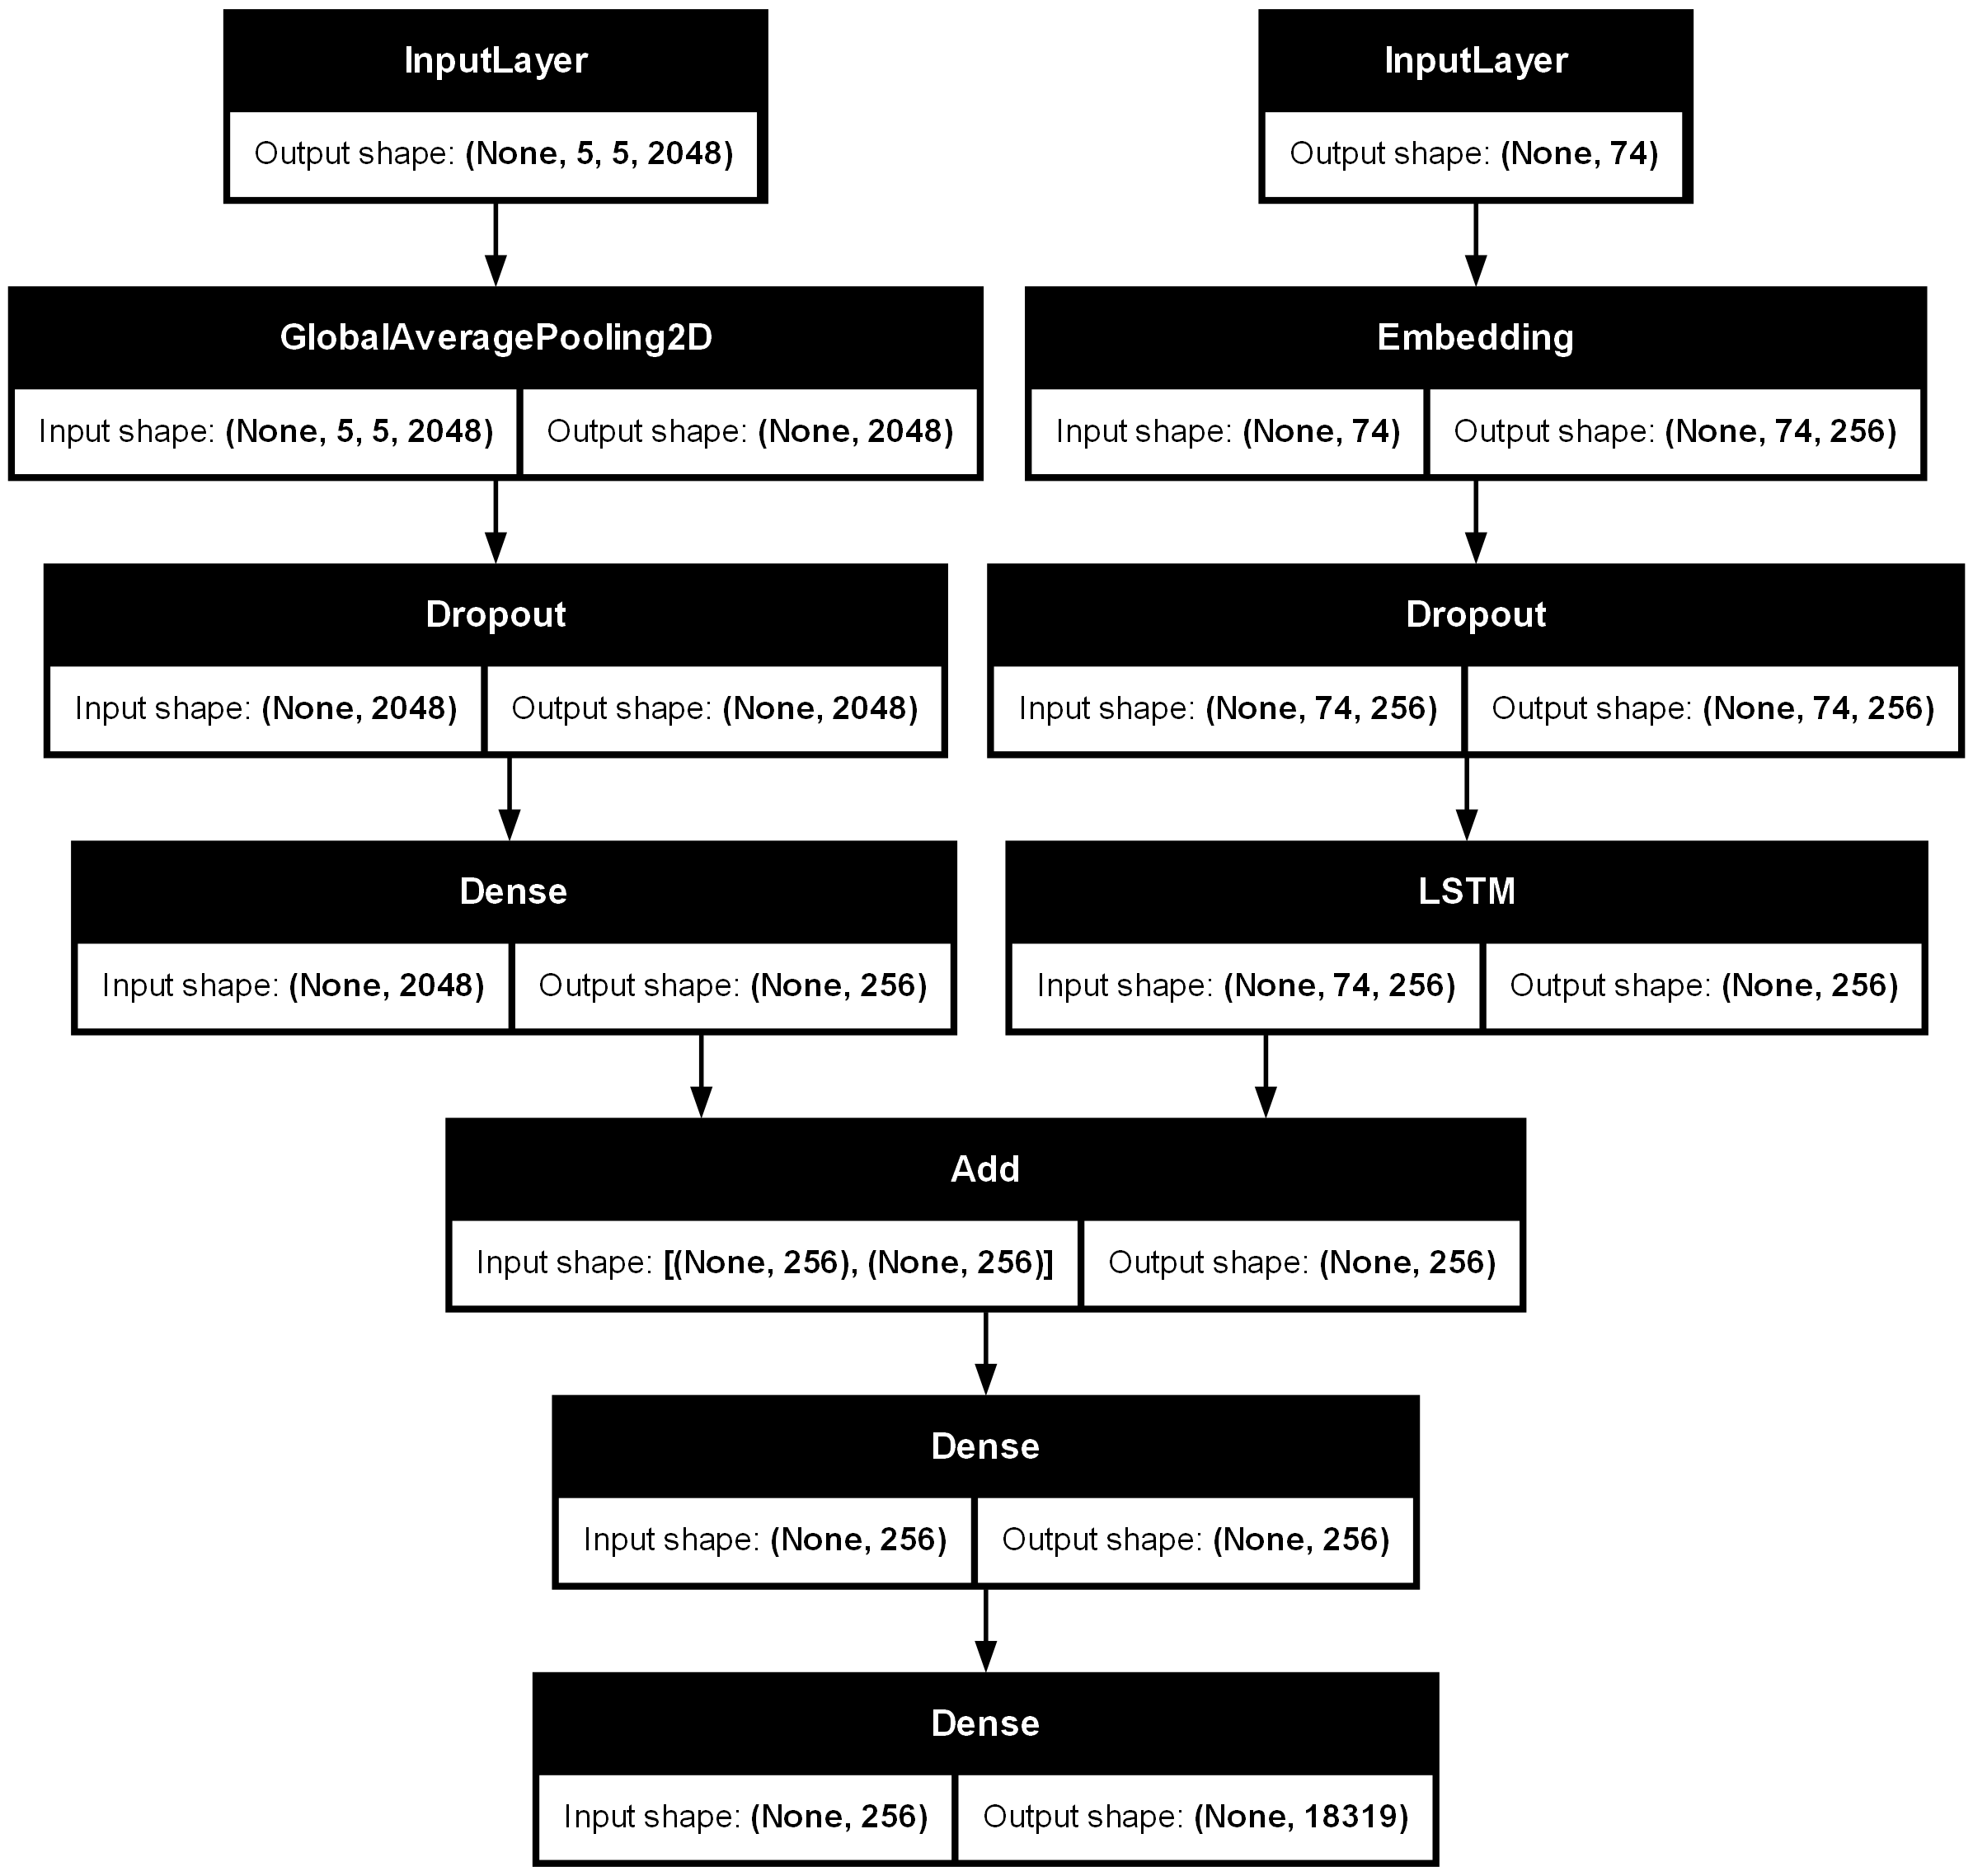

In [ ]:
plot_model(model, show_shapes = True)

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 5, 5,      │          0 │ -                 │
│                     │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text (InputLayer)   │ (None, 74)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ image[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 74, 256)   │  4,689,664 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 74, 256)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    524,544 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 18319)     │  4,707,983 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,513,295 (40.11 MB)

 Trainable params: 10,513,295 (40.11 MB)

 Non-trainable params: 0 (0.00 B)

## Training the model

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'best_model.keras',
    save_best_only = True, 
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 1
    )

In [ ]:
with strategy.scope():
    epochs = 3
    batch_size = 32
    steps = len(train_set) // batch_size
    validation_steps = len(validation_set)//batch_size
    
    tensorboard = TensorBoard(log_dir = 'logs')
    
    for i in range(epochs):
        generator = data_generator(train_set, mapping, features, tokenizer, max_length, vocab_size, batch_size)
        val_generator = data_generator(validation_set, mapping, features, tokenizer, max_length, vocab_size, batch_size)
        history = model.fit(generator, validation_data = val_generator, epochs = 1, 
                  steps_per_epoch = steps, validation_steps = validation_steps,
                  verbose = 1, 
                  callbacks = [checkpoint_callback, tensorboard])

595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - loss: 6.7331
Epoch 1: val_loss improved from inf to 5.69567, saving model to best_model.keras
595/595 ━━━━━━━━━━━━━━━━━━━━ 782s 1s/step - loss: 6.7320 - val_loss: 5.6957
595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - loss: 5.4677
Epoch 1: val_loss improved from 5.69567 to 5.18838, saving model to best_model.keras
595/595 ━━━━━━━━━━━━━━━━━━━━ 769s 1s/step - loss: 5.4674 - val_loss: 5.1884
595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - loss: 4.9094

In [ ]:
with strategy.scope():
    os.mkdir('model-saves')
    model.save(WORKING_DIR + "/model-saves" + "/image_captioning-model.keras")

## Generating captions for the image

In [ ]:
def idx_to_word(word_number, tokenizer):
    """
    Input:
    word_number --> the number used to 
    """
    for word, index in tokenizer.word_index.items():
        if index == word_number:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenzier, max_length):
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose = 0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        
        in_text += " " + word
        
        if word is None:
            break
        
        if word == "endseq":
            break
    return in_text

In [ ]:
# Validating with the text data
actual = list()
predicted = list()

for key in test_set:
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
    
    
# Computing BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights = (1, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights = (1/3, 1/3, 1/3)))

## Output Visualisation

In [ ]:
def generate_caption(image_name):
    image = Image.open(img_path)
    image_id = image_name.split(".")[0]
    captions = mapping[image_id]

    print("--------------- Actual Captions ---------------")
    for caption in captions:
        print(caption)

    print("--------------- Predicted Caption ---------------")    
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print(y_pred)
    plt.imshow(image)

In [ ]:
# loaded_model = tf.keras.models.load_model('image-captioning-model.keras')

--------------- Actual Captions ---------------
startseq man in blue jacket has fallen asleep while sitting on fold-able chair with fishing pole and green umbrella endseq
startseq one man in blue jacket is sitting in the rain under green umbrella endseq
startseq man is fishing on the dock despite the dreary weather endseq
startseq man relaxes in chair as he fishes on rainy day endseq
startseq man is trying to find shelter from the rain endseq
--------------- Predicted Caption ---------------
startseq woman in blue shirt is sitting on bench endseq


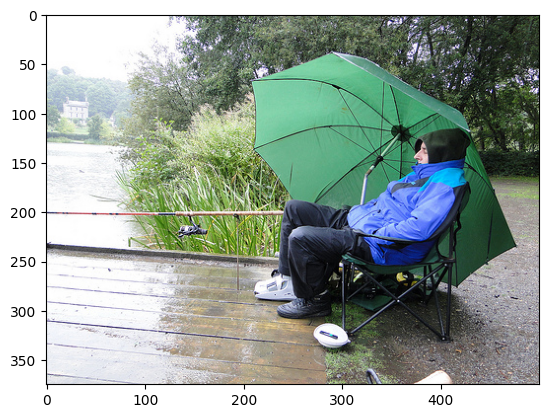

In [ ]:
generate_caption(test_set[52] + '.jpg')

--------------- Actual Captions ---------------
startseq blond woman dressed in white skirt with pink polka dots and "" pink ladies "" leather jacket and man in black leather jacket and sunglasses wait on sidewalk ." endseq
startseq woman wearing pink ladies jacket and polka dot skirt with red shoes stands by man in leather coat endseq
startseq the woman in the pink and white dress is holding bottle of water endseq
startseq the older lady in the white skirt is wearing pink shoes endseq
startseq couple stand outside in grease 50 's costume endseq
--------------- Predicted Caption ---------------
startseq woman in black dress and black skirt is walking down the street endseq


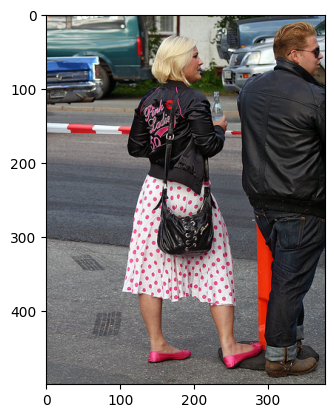

In [ ]:
generate_caption(test_set[155] + '.jpg')